In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

### Entity Embeddings

Variables are of two types: Categorical and Numeric. Categorical variables are those which discrete set of values in form of categories. In a dataset, there can be many categorical variables which can have categories in form of text or numbers. However, we need to preprocess such variables for the ML model to interpret them appropriately. For example, if we have a variable as gender having values as 'Male' and 'Female', we need to map these categories appropriately such that we represent them through numbers. At the same time, there is no relation between mapped values of 'Male' and 'Female' as these categories are independent.

There are many preprocessing techniques like One Hot Encoding, Label Encoding etc. However, these techniques have certain limitations:
1. One Hot Encoding: Increase volume of dataset drastically while transforming high cardinalility features and making it sparse
2. Label Encoding: Inducing dependency between categories

And so, we can go with an approach like Entity Embeddings when we have a very large number of categorical variables. The idea behind Entity Embeddings is that it uses a Neural Network to learn embeddings for each categorical variable with minimizing the objective. 

#### Kaggle Dataset Link: https://www.kaggle.com/c/cat-in-the-dat

In [2]:
num_classes = 2
sample_frac = 1

max_ebd_size = 20
dense_dim = 50
dropout_rate = 0.5

learning_rate = 5E-5
n_epochs = 30
batch_size = 1024

data = pd.read_csv('cat-in-the-dat/train.csv')

In [3]:
# taking small sample of data for faster training
data1 = data[data['target']==0].sample(frac=sample_frac)
data2 = data[data['target']==1].sample(frac=sample_frac)
data = pd.concat([data1, data2])

In [4]:
train, val = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=0)
len(train), len(val)

(240000, 60000)

Important Points:

1. Note that there is an Embedding layer for each categorical variable which is connected to its own layer only and not to other input variables or embeddings. 
2. In that sense, the Neural Network will have an input layer for each variable in data. So there are **multiple inputs** in this NN. 
3. The Embedding layers are flattened and concatenated into a dense layer. 
4. Post that, additional set of Dense, Dropout, Batch Normalization layers are added accordingly to build the NN with the target objective.


In [5]:
cols = data.columns.tolist()
cols.remove('id')
cols.remove('target')

inputs = []
outputs = []
for col in cols:
    lbl_enc = LabelEncoder()
    lbl_enc.fit(data[col].values)
    
    # transforming variables to numeric form
    train.loc[:, col] = lbl_enc.transform(train[col].values)
    val.loc[:, col] = lbl_enc.transform(val[col].values)
    
    num_unique_values = data[col].nunique()
    
    # add one for unknown
    input_size = num_unique_values + 1
    
    # embedding size
    output_size = min(num_unique_values // 2, max_ebd_size)
    
    ebd_layer = layers.Embedding(input_size, output_size)
    inp = layers.Input(shape=(1,))
    out = ebd_layer(inp)
    out = layers.Reshape(target_shape=(output_size, ))(out)
    
    inputs.append(inp)
    outputs.append(out)

2022-03-14 15:38:40.119972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
x = layers.Concatenate()(outputs)
x = layers.Dense(dense_dim, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
y = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=y)
print('Number of parameters:', model.count_params())

Number of parameters: 336806


In [7]:
X_train = [train.loc[:, c].values for c in cols]
X_val = [val.loc[:, c].values for c in cols]
y_train = train['target'].values
y_val = val['target'].values

len(X_train), len(X_val), len(y_train), len(y_val)

(23, 23, 240000, 60000)

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
estop = EarlyStopping(patience=3)

history = model.fit(X_train, y_train, epochs = n_epochs, shuffle = True, 
                    batch_size = batch_size, validation_data = (X_val, y_val), callbacks = [estop], verbose=2)

Epoch 1/30
235/235 - 4s - loss: 0.8474 - accuracy: 0.5257 - val_loss: 0.6635 - val_accuracy: 0.6862 - 4s/epoch - 18ms/step
Epoch 2/30
235/235 - 1s - loss: 0.7143 - accuracy: 0.5790 - val_loss: 0.6373 - val_accuracy: 0.6887 - 1s/epoch - 6ms/step
Epoch 3/30
235/235 - 1s - loss: 0.6536 - accuracy: 0.6283 - val_loss: 0.6138 - val_accuracy: 0.6916 - 1s/epoch - 5ms/step
Epoch 4/30
235/235 - 1s - loss: 0.6182 - accuracy: 0.6690 - val_loss: 0.5906 - val_accuracy: 0.7048 - 1s/epoch - 6ms/step
Epoch 5/30
235/235 - 1s - loss: 0.5918 - accuracy: 0.6929 - val_loss: 0.5670 - val_accuracy: 0.7184 - 1s/epoch - 6ms/step
Epoch 6/30
235/235 - 1s - loss: 0.5697 - accuracy: 0.7113 - val_loss: 0.5481 - val_accuracy: 0.7282 - 1s/epoch - 6ms/step
Epoch 7/30
235/235 - 1s - loss: 0.5541 - accuracy: 0.7213 - val_loss: 0.5359 - val_accuracy: 0.7340 - 1s/epoch - 6ms/step
Epoch 8/30
235/235 - 1s - loss: 0.5409 - accuracy: 0.7300 - val_loss: 0.5265 - val_accuracy: 0.7395 - 1s/epoch - 5ms/step
Epoch 9/30
235/235 - 1s

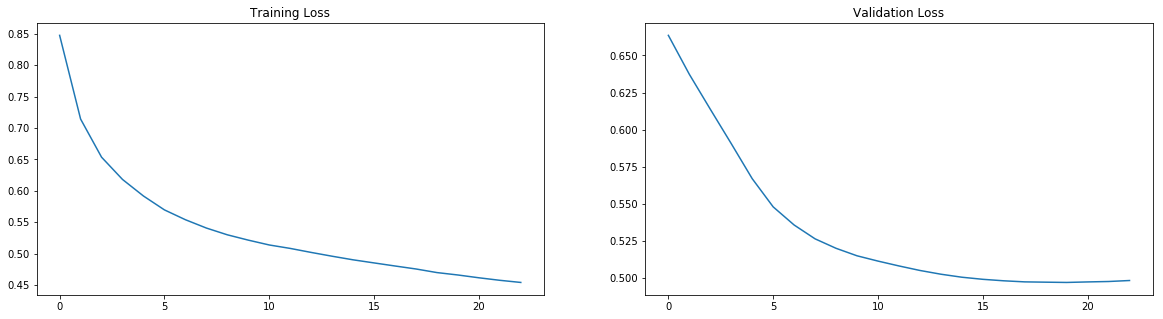

In [9]:
plt.figure(figsize=(20,5))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(121)
plt.plot(train_loss)
plt.title('Training Loss')

plt.subplot(122)
plt.plot(val_loss)
plt.title('Validation Loss')
plt.show()